Inspired on https://docs.fast.ai/tutorial.siamese.html

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
import PIL

In [2]:
path = Path("/storage/cs7643/images/")

In [3]:
fns = get_image_files(path)
fns

(#101000) [Path('/storage/cs7643/images/chocolate_mousse/1667209.jpg'),Path('/storage/cs7643/images/chocolate_mousse/3511892.jpg'),Path('/storage/cs7643/images/chocolate_mousse/1347268.jpg'),Path('/storage/cs7643/images/chocolate_mousse/1092783.jpg'),Path('/storage/cs7643/images/chocolate_mousse/1402394.jpg'),Path('/storage/cs7643/images/chocolate_mousse/3747713.jpg'),Path('/storage/cs7643/images/chocolate_mousse/116066.jpg'),Path('/storage/cs7643/images/chocolate_mousse/3413472.jpg'),Path('/storage/cs7643/images/chocolate_mousse/1478338.jpg'),Path('/storage/cs7643/images/chocolate_mousse/1407108.jpg')...]

In [4]:
labels = list(set(fns.map(parent_label)))
len(labels)

101

In [5]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [6]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.splbl2files = [{l:[f for f in files[splits[i]] if parent_label(f) == l] for l in labels} for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f,0))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = parent_label(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]), 1*same

In [7]:
splits = RandomSplitter()(fns)

In [8]:
tfm = SiameseTransform(fns, splits)

In [9]:
tls = TfmdLists(fns, tfm, splits=splits)

<AxesSubplot:title={'center':'1'}>

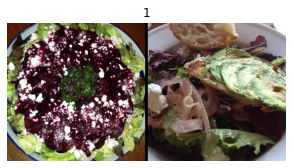

In [10]:
show_at(tls.valid, 0)

In [11]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [12]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

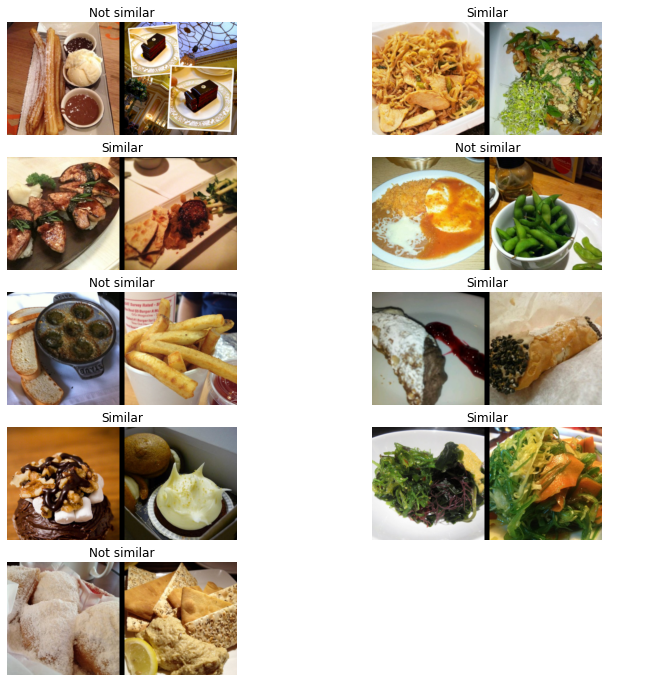

In [13]:
dls.show_batch()

In [14]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [15]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [17]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [18]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [19]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [20]:
learn.freeze()

SuggestedLRs(valley=0.0002754228771664202)

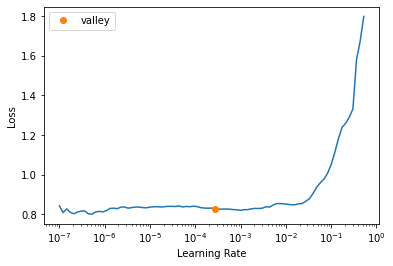

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.667481,0.625685,0.648960,08:58
1,0.632651,0.588927,0.691881,09:01


SuggestedLRs(valley=0.00010964782268274575)

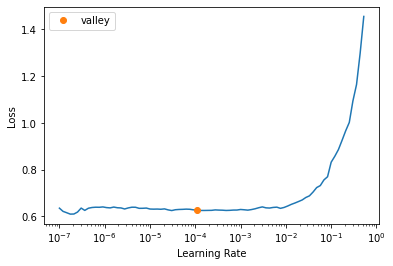

In [23]:
learn.lr_find()

In [24]:
learn.export('similarity.pkl')

In [25]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
